# Dev information:
* Header style is defined in the above cell which needs not to be skipped
* Compile via `./presentation_gen.sh`
* Requirements: run
    `poetry install --extra presentation`
    `poetry run install_presentation

* Note bug in tikzmagic that requires -f svj

In [21]:
%load_ext tikzmagic

# The `w7x` package
## A Simulation Framework
[<img src="https://img.shields.io/pypi/v/w7x.svg">](https://pypi.python.org/pypi/w7x) [<img src="https://img.shields.io/badge/pipeline-passed-green">](https://gitlab.mpcdf.mpg.de/dboe/w7x/commits/master) [<img src="https://img.shields.io/badge/coverage-79%25-green">](https://gitlab.mpcdf.mpg.de/dboe/w7x/commits/master) [<img src="https://img.shields.io/website-up-down-green-red/https/dboe.pages.mpcdf.de/w7x.svg?label=docs">](https://dboe.pages.mpcdf.de/w7x) [<img src="https://img.shields.io/badge/pre--commit-enabled-brightgreen?logo=pre-commit&logoColor=white">](https://github.com/pre-commit/pre-commit)


The `w7x` package is a
* **simulation framework** that
* provides high level **interfaces for simulation codes** with interchangeable **backends**
* allows to build **computation pipelines** in a directed acyclic **graph**.

* It provides access to simulation codes such that users do **not need to be domain experts** of the specific codes and
* **will take care** about particularities like binary installation, sanity checks, output files/format, passing on the output to follow-on codes etc.

The package is named after the Wendelstein 7-X stellarator, but it is **generic** enough to be used for any **magnetic confinement fusion** device.


## Content

- **Teaser**
- **Problem description**
- **Solution Concepts** → Simultaneous introduction into **Usage**
- **Infrastructure**



# [Teaser](https://dboe.pages.mpcdf.de/w7x/lib/usage/index.html)

In [2]:
import w7x
import tfields
from w7x.simulation.vmec import Vmec
from w7x.simulation.backends.nn.vmec import VmecNNBackend
from w7x.simulation.extender import Extender
from w7x.simulation.flt import FieldLineTracer
from w7x.simulation.components import Components

vmec = Vmec()
extender = Extender()
extender.strategy = "web_service"
flt = FieldLineTracer()
comps = Components()

phi = 0

state = w7x.State(
    w7x.config.Assemblies.Pfcs(),
    w7x.config.CoilSets.Ideal(),
    w7x.config.Plasma.Vacuum(),
)
params = dict(
    seeds=tfields.Points3D([[5.8, 0.0, 0.0]], coord_sys="cartesian"),
    phi=phi,
    n_points=100,
)
kwargs = dict(scheduler=dict(n_workers=4))

In [3]:
# mock compute
def compute(*args, **kwargs):
    return w7x.State()


compute_old = w7x.compute
w7x.compute = compute


def unmock():
    w7x.compute = compute_old

In [4]:
import w7x

vmec.strategy = "local"  # interchangeable

with w7x.distribute(True):
    # define the graph
    graph = vmec.free_boundary(state)
    graph = extender.field(graph)
    graph = flt.trace_poincare(graph, **params)
    graph = w7x.State.merged(graph, comps.mesh_slice(state, phi=phi))  # parallel

    # start execution
    state = w7x.compute(graph, **kwargs)

    # store
    state.save("my_state.dill")

![distributed computing](../images/distributed_computing.gif)

# Problem Description

### Problem I - Domain Knowledge

Every developer is **experienced with few simulation codes** and **beginner in many others**.


- Usage of codes often **requires considerable expert knowledge**
    - Installation / Setup
    - Input preparation, good default values and parameters?
    - Execution
    - Outer schemes (e.g. outer optimization, inverse modeling, self-consistency feedback, ...)
    - Result validation
    - Result interpretation
- Various paths
    - Expert does it → <span style="color:orange">overloaded expert</span> → inefficient
    - Expert supports → <span style="color:orange">overloaded expert</span> → error prone & inefficient
    - <span style="color:orange">Overloaded expert</span> → User tries alone → very error prone & inefficient

### Problem II - Inter-Code Communication
- Currently: **point-to-point data communication**
    - every code requires individual routines depending on the previous/following step in the computation pipeline (i.e. converting files)
    - "information loss" (i.e. intermediate pipeline outputs do not include all initial information
    - → **Scales bad: $\lessapprox\mathcal{O}(n_\text{codes}!)$**

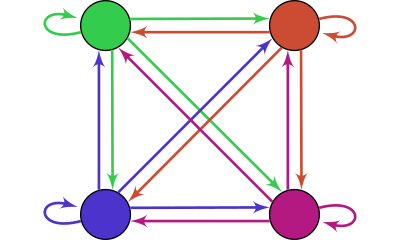

In [22]:
%%tikz -f svg -l positioning,arrows,calc
% https://tex.stackexchange.com/questions/485486/two-parallel-lines-between-nodes-of-arbitrary-size-and-position
\tikzset{shifted path/.style args={from #1 to #2 by #3}{insert path={
let \p1=($(#1.east)-(#1.center)$),
\p2=($(#2.east)-(#2.center)$),\p3=($(#1.center)-(#2.center)$),
\n1={veclen(\x1,\y1)},\n2={veclen(\x2,\y2)},\n3={atan2(\y3,\x3)} in
(#1.{\n3+180+asin(#3/\n1)}) to (#2.{\n3-asin(#3/\n2)})
}}}
\tikzset{vertex/.style = {shape=circle,draw,minimum size=1.5em}}
\tikzset{edge/.style = {->,> = latex',thick}}

\definecolor{c1}{rgb}{0.2,0.8,0.3}
\definecolor{c2}{rgb}{0.8,0.3,0.2}
\definecolor{c3}{rgb}{0.3,0.2,0.8}
\definecolor{c4}{rgb}{0.7,0.1,0.5}

% vertices
\node[vertex,fill=c1] (a) at  (0,0) {};
\node[vertex,fill=c2] (b) at  (2,0) {};
\node[vertex,fill=c3] (c) at  (0,-2) {};
\node[vertex,fill=c4] (d) at  (2,-2) {};

\draw[edge,c1,->] (a) edge[loop left] (a);
\draw[edge,c1,->,shifted path=from a to b by 2 pt];
\draw[edge,c1,->,shifted path=from a to c by 2 pt];
\draw[edge,c1,->,shifted path=from a to d by 2 pt];

\draw[edge,c2,->] (b) edge[loop right] (b);
\draw[edge,c2,->,shifted path=from b to a by 2 pt];
\draw[edge,c2,->,shifted path=from b to c by 2 pt];
\draw[edge,c2,->,shifted path=from b to d by 2 pt];

\draw[edge,c3,->] (c) edge[loop left] (c);
\draw[edge,c3,->,shifted path=from c to a by 2 pt];
\draw[edge,c3,->,shifted path=from c to b by 2 pt];
\draw[edge,c3,->,shifted path=from c to d by 2 pt];

\draw[edge,c4,->] (d) edge[loop right] (d);
\draw[edge,c4,->,shifted path=from d to a by 2 pt];
\draw[edge,c4,->,shifted path=from d to b by 2 pt];
\draw[edge,c4,->,shifted path=from d to c by 2 pt];


- The different simulation codes are not closely integrated
    - → **Human in the loop**: Often result files + routines are passed around
    - → Spawning of multiple adaptations of routines without convergence
    - → error-prone procedures / trust in results?
    - → **information loss / reproducability?**
    - → **inefficient**

## Problem III - Signatures
> Signature = "Unique combination of an object's name and its parameters' positions and types"

Flavours and Backends have different signatures
- Flavours: For some problems multiple (competing) solvers/simulations exists. Although they ultimately do the same thing, each one requires their own expert → **Further dimension of Problem II**
- Backends: Multiple codes have **different execution contexts** (local, web-service, high performance cluster, interpolators, ...) with each again different interfaces → **Further dimension of Problem II**

## Problem IV - Collaboration
- **Indicator for low level of cooperation** in software development: Currently Most Stars on an IPP project on **gitlab.mpcdf.mpg.de** are **11☆** (similar on git.ipp-hgw.mpg.de)
    - Fun fact: Among top 15 is a public bachelor thesis repo with **3☆**
- Among the reasons:
    - Codes with **low abstraction levels** are **costly to tailor to ones needs**    

## Problem V - Data Scattering
> Data scattering: distribution of related data across multiple entities, leading to a lack of cohesion. The data becomes fragmented and spread across different components or variables.

Examples:

In [7]:
def compute(profile_coefficients, profile_type="parabolic"):
    ...


def compute(
    *args,
    points=[[1, 2, 3]],
    data=[[5, 6, 7]],
    coordinate_system="cartesian",
    unit="nW"
):
    # mostly these information are implicitly assumed
    ...


Issues:
- Long signatures, cluttered namespace
- Reduced readability: Harder to understand relationships and context.
- Increased complexity: Difficulty in maintenance and modification.
- Difficulty in extensibility: Complex changes in multiple places.
- Information loss: Often some parts of the metadata are implicitly assumed

## Problem VI - Hard-coding
> Hard-coding: Practice of directly embedding values or specific logic into the code

It can include hard-coded
- values,
- constants, or
- any fixed implementation that is not easily modifiable

# Solution Concepts

## Data Encapsulation
> Data encapsulation: The practice of **bundling data and related functionality within a single object**, while hiding implementation details and providing controlled access through defined interfaces.

- Improved code organization and structure
- Enhanced reusability and modularity
- Easier maintenance and updates

→ Solves:
- Problem V - Data Scattering

→ Addresses:
- Problem III - Signatures

In [8]:
import w7x
import tfields

Examples:

In [9]:
def compute(profile: w7x.lib.profiles.Profile):
    ...


def compute(*args, tensor: tfields.TensorFields):
    ...

## Interfaces & Abstraction


> Interface: **defines contract for classes to follow**. Interfaces are used to **achieve abstraction** and **ensure** that classes and their methods adhere to specific **behavior**

→ Addresses:
- Problem IV - Collaboration
- Problem III - Signatures

Example:

![](../images/uml-abstraction.png)

## Strategy Design Pattern

> Strategy Desing Pattern: Behavioral design pattern that allows to **define a family of encapsualted, interchangeable algorithms**. The **algorithm can vary independently of the clients** that use it.

![](../images/strategy-design-pattern.png)


> Liskov Substitution Principle (LSP): Subclasses should be substitutable for their base classes without altering the correctness of the program.

**Implementation:**

![](../images/uml-strategy.png)

→ Solves:
- Problem III - Signatures (together with Abstraction - see above)

→ Addresses:
- Problem I - Domain Knowledge (Interchangeability → apply knowledge to all of the same kind)

**Example:**

In [10]:
from w7x.simulation.vmec import Vmec

vmec = Vmec()

Comes with default backend

In [11]:
vmec.backend

Switching a backend:

In [12]:
from w7x.simulation.backends.nn.vmec import VmecNNBackend

# strings map to internal backends
vmec.backend = "slurm"
print(vmec.backend)

# Define your own backend and set explicitly
vmec.backend = VmecNNBackend
print(vmec.backend)

![Currently implemented:](../images/table-frontend-backend.png)

## Automation
**Automate the routines that can be automated e.g.:**
- Outer schemes:
    - Vmec: `vmec.search(beta=0.05, volume=30, b_axis=2.5)`
    - FieldLineTracer: Automatic Seed generation, depth control, forward and backward tracing
    - Extender: parallelized subfield generation
    - ...
- Result validation:
    - `vmec.free_boundary` calls `vmec._converge` internally
    - ...

Addresses:
- Problem I - Domain Knowledge

## Centralized data communication

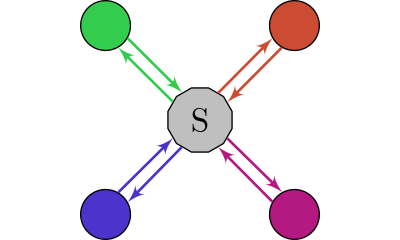

In [13]:
%%tikz -f svg -l positioning,arrows,calc,shapes
% https://tex.stackexchange.com/questions/485486/two-parallel-lines-between-nodes-of-arbitrary-size-and-position
\tikzset{shifted path/.style args={from #1 to #2 by #3}{insert path={
let \p1=($(#1.east)-(#1.center)$),
\p2=($(#2.east)-(#2.center)$),\p3=($(#1.center)-(#2.center)$),
\n1={veclen(\x1,\y1)},\n2={veclen(\x2,\y2)},\n3={atan2(\y3,\x3)} in
(#1.{\n3+180+asin(#3/\n1)}) to (#2.{\n3-asin(#3/\n2)})
}}}
\tikzset{vertex/.style = {shape=circle,draw,minimum size=1.5em}}
\tikzset{edge/.style = {->,> = latex',thick}}

\definecolor{c1}{rgb}{0.2,0.8,0.3}
\definecolor{c2}{rgb}{0.8,0.3,0.2}
\definecolor{c3}{rgb}{0.3,0.2,0.8}
\definecolor{c4}{rgb}{0.7,0.1,0.5}

% vertices
\node[vertex,fill=c1] (a) at  (0,0) {};
\node[vertex,fill=c2] (b) at  (2,0) {};
\node[vertex,fill=c3] (c) at  (0,-2) {};
\node[vertex,fill=c4] (d) at  (2,-2) {};
\node[regular polygon, regular polygon sides=12,draw,minimum size=2em,fill=lightgray] (s) at (1,-1) {S};

\draw[edge,c1,->,shifted path=from a to s by 2 pt];
\draw[edge,c1,->,shifted path=from s to a by 2 pt];

\draw[edge,c2,->,shifted path=from b to s by 2 pt];
\draw[edge,c2,->,shifted path=from s to b by 2 pt];

\draw[edge,c3,->,shifted path=from c to s by 2 pt];
\draw[edge,c3,->,shifted path=from s to c by 2 pt];

\draw[edge,c4,->,shifted path=from d to s by 2 pt];
\draw[edge,c4,->,shifted path=from s to d by 2 pt];


**Standardized data format:**
* Interfaces are workflow independent (plug new models & play)
* Scales well $\mathcal{O}(n_\text{codes})$


→ Solves:
- Problem II - Inter-Code Communication

→ Addresses:
- Problem IV - Collaboration
- Problem V - Data Scattering

→ Challenge:
- **Requires state model/schema** that is curated or accepted among all parties

## Composite Design Pattern

> Composite Design Pattern: Structural design pattern that allows you to treat a group of hierarchical objects as a single object

![Work with trees like with individual objects](../images/composite-design-pattern-tree.png)


![Encapsulates complex hierarchies](../images/composite-design-pattern-boxes.png)

![Scales through recursive delegation](../images/composite-design-pattern-recursion.png)

 ![](../images/composite-design-pattern.png)

![](../images/uml-composite.png)

![](../images/uml-composite-state.png)

![](../images/uml-composite-state-coil.png)

![](../images/uml-composite-state-model.png)

→ Solves:
- Problem II - Inter-Code Communication (part of state)

→ Addresses:
- Problem IV - Collaboration
- Problem VI - Hard-coding

## Creational Patterns

> object creation mechanisms, which increase flexibility and reuse of existing code

- Allows definition of default templates for **creation of specific state components**

![w7x specific schema](../images/outline-config-coils.png)

Example:

In [14]:
state = w7x.State(
    w7x.config.Assemblies.Pfcs(),
    w7x.config.CoilSets.Ideal(),
    w7x.config.Plasma.Vacuum(),
)
state.coil_set

CoilSets.Ideal(id=None, name='ideal w7x coil set', info=None, coils=[CoilGroups.IdealNonPlanar(id=None, name='ideal non planar coils', info=None, coils=[CoilTypes.NonPlanar(id=160, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=161, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=162, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=163, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=164, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=165, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=166, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=167, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=168, name=None, info=None, n_windings=108, current=13200.0), CoilTypes.NonPlanar(id=169, name=None, info=None, n_windings=108, current=13200.0), CoilTyp

→ Solves:
- Problem II - Inter-Code Communication (part of state)

→ Addresses:
- Problem III - Signatures
- Problem IV - Collaboration
- Problem VI - Hard-coding

## Functional Programming
> Functional programming: programming paradigm that emphasizes the use of pure functions, immutability, and the avoidance of side effects. It treats computation as the evaluation of mathematical functions and promotes higher-order functions, function composition, and declarative programming style.

￼￼



In [15]:
def trace_diffusion(state, **kwargs) -> w7x.State:
    ...  # do computation
    state = w7x.State.merged(state, w7x.model.Traces())
    return state

In [16]:
state = w7x.State(w7x.model.Equilibrium())

In [17]:
trace_diffusion(state)

State object with keys ['equilibrium', 'traces']

## Default Transparency

> Default-transparency: Usage of defaults should be implicitly visible from the return value metadata

In [18]:
state = w7x.State(w7x.model.Equilibrium())

In [19]:
@w7x.dependencies(
    w7x.config.CoilSets.Ideal,
    w7x.config.Assemblies.Pfcs,
    w7x.config.Plasma.Vacuum,
    start_points=w7x.dependencies.REQUIRED,
    step=5e-2,
    connection_limit=3e4,
    inverse_field=False,
)
def trace_diffusion(state, **kwargs) -> w7x.State:
    return w7x.model.Traces()

> In the face of ambiguity, refuse the temptation to guess

In [20]:
try:
    trace_diffusion()
except AttributeError as err:
    print(str(err))

Parameter 'start_points' required


**Default transparency:**

In [21]:
trace_diffusion(start_points=42)

State object with keys ['coil_set', 'assembly', 'plasma_parameters', 'traces', 'history']

> Explicit is better than implicit

**Automatic merge** (equilibrium from initial state)

In [22]:
trace_diffusion(state, start_points=42)

State object with keys ['equilibrium', 'coil_set', 'assembly', 'plasma_parameters', 'traces', 'history']

→ Solves:
- Problem VI - Hard-coding (together with hydra config)

→ Addresses:
- Problem I - Domain Knowledge (by clearly defining and transparently supplementing defaults)
- Problem II - Inter-Code Communication (information loss)


## Distributed Computing

> Distributed computing: Defining the computation pipeline/graph before execution allows optimiazion of work-load


In [23]:
# SIGNATURE


@w7x.node
def trace_diffusion_distributed(state: w7x.State, **kwargs) -> w7x.State:
    ...  # do computation
    return w7x.model.Traces()

In [24]:
trace_diffusion_distributed(state)  # By default the w7x.node does not change anything

Traces(lcfs_point=None, trajectories=None, surface=None, poincare_surfaces=None)

In [25]:
unmock()

In [26]:
with w7x.distribute(True):  # You have to switch it on explicitly
    graph = trace_diffusion_distributed(state)
state = w7x.compute(graph)
graph, state

(Delayed('trace_diffusion_distributed-255c8863-6fd2-405d-84c5-94c61810039d'),
 Traces(lcfs_point=None, trajectories=None, surface=None, poincare_surfaces=None))

## Orthogonality

> Orthogonality: Independent and modular components, minimal dependencies and interactions

- All of the above concepts are **separable** where possible e.g. "only use the @w7x.node for distributed computation"


**Put it all together**

In [27]:
@w7x.dependencies.extends(trace_diffusion)
@w7x.node
def trace_diffusion_distributed(state: w7x.State, **kwargs) -> w7x.State:
    ...  # do computation
    return w7x.model.Traces()

In [28]:
with w7x.distribute(True):
    graph = trace_diffusion_distributed(state, start_points=42)
state = w7x.compute(graph)
graph, state

(State object with keys ['traces', 'coil_set', 'assembly', 'plasma_parameters', 'history'],
 State object with keys ['traces', 'coil_set', 'assembly', 'plasma_parameters', 'history'])

### Infrastructure

### Pypi

```bash
pip install w7x
```

![](../images/pre-commit.png)

Unit tested with **~80 % coverage**

![](../images/coverage-report.png)

## Summary
The w7x package is a powerfull **simulation framework** for simulation pipelines with centralized comunication. Some code are already included.
Benefits include:
- Coupling codes efficiently
- Scales well with the number of integrated codes
- Is still flexible - use the parts you like
- Scalable
- Distributed computing
- Tested (high coverage)
- Transparent
- Reproducibility
- Constistent industry standard style: pylint score: 9/10

It is not the silver bullet but solves some problems systematically.

## Why did I give this presentation?
- Inform about existence
- Promote usage
- I am proposing this as a standard to systematically be used
- **Get involved by including your domain-knowledge** and benefit from others doing the same!
    - → Write your own Backends/Codes/Flavours or improving the model/config
    - → **Happy to help and get you started**

> *Lets move on from artisanal software development to industry scale*

# Backup

# w7x.State - Basics

In [ ]:
import w7x

In [ ]:
state = w7x.State()
state

In [ ]:
import w7x.simulation.vmec

In [ ]:
state = w7x.State()
state

In [ ]:
state.add(
    w7x.config.CoilSets.Ideal.from_currents(
        *w7x.config.MagneticConfig.high_iota_rw, unit="rw"
    )
)

In [ ]:
import numpy as np

sphere = tfields.Mesh3D.grid(
    (1, 1, 1), (-np.pi, np.pi, 12), (-np.pi / 2, np.pi / 2, 12), coord_sys="spherical"
)
sphere.transform("cartesian")
sphere[:, 1] += 2

In [ ]:
sphere.plot(dim=3, edgecolor="k")

In [ ]:
comp = w7x.model.Component()
comp.mesh = sphere

In [ ]:
ass = w7x.config.Assemblies.Pfcs()
ass.add(comp)
state.add(ass)
state.assembly

# Line Tracing

## Definition of Experiment:

In [ ]:
import w7x
import tfields
import numpy as np
import matplotlib.pyplot as plt

Experiment defined by magnetic configuration and machine components

In [ ]:
magnetic_config = w7x.flt.MagneticConfig.default()
machine = w7x.flt.Machine.default()
experiment = w7x.flt.Run(magnetic_config, machine)

Where reasonable: Classes have a 'default' factory method.
E.g default for magnetic_config is vacuum standard case:

In [ ]:
magnetic_config.coil_currents("rw")

## Poincare Plots

In [ ]:
import logging
import numpy as np
import rna.plotting
import tfields
import w7x
import w7x.simulation.flt
import w7x.simulation.components
import w7x.plotting.poincare
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)


def compute(phi):
    """poincare plot creation"""
    assembly = w7x.model.Assembly(
        components=[
            w7x.config.AssemblyGroups.Vessel(),
            w7x.config.AssemblyGroups.Divertor(),
        ]
    )

    flt = w7x.simulation.flt.FieldLineTracer()
    components = w7x.simulation.components.Components()
    with w7x.distribute(True):
        graph = w7x.State.merged(
            components.mesh_slice(assembly, phi=phi),
            # pylint:disable=no-value-for-parameter
            flt.trace_poincare(
                phi=phi,
                seeds=tfields.Points3D([[5.8, 0.0, 0.0], [6.0, 0.0, 0.0]]),
                n_points=100,
            ),
        )
        # graph.visualize(filename="poincare_graph.pdf")
        state = w7x.compute(graph, cache="poincare_state.dill")

    return state

In [ ]:
%matplotlib notebook
phi = 171.2 / 180 * np.pi
state = compute(phi)

# plotting
rna.plotting.set_style()
axes = plt.gca()
axes.grid(color="lightgrey")
poincare_figure = w7x.plotting.poincare.Poincare()
poincare_figure.plot(state, phi=phi, ax=axes)
# poincare_figure.save("~/tmp/poincare", extension=["png", "pgf", "pdf"])
plt.show()

![](~/tmp/poincare.png)

## IMAS as State Schema

[IMAS](https://gafusion.github.io/omas/schema.html) is a data schema defined/managed by ITER
- Pro: Predefined schema from the Tokamak community
- Con:
    - Tokamak centric (e.g. only planar schema), Many stellarator requirements not met
    - + Long development cycles
    - → Impractical for development
    
- Initially defining a generic schema, as close as possible to IMAS
- Mapping possible
- Integrating with IMAS requires extra resources (Manpower dedication) because IMAS would need to change